# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
from scipy import stats

rng = np.random.default_rng(1)
x = rng.uniform(-2, 2, 200)

log_sigma = -1.0 + 0.3 * (
    0.5 * x + 15 * stats.norm.pdf(2 * (x - 0.2)) - stats.norm.pdf(x + 0.4)
)
mu = -x + np.pi * np.sin(np.pi * x)
y = mu + jnp.exp(log_sigma) * rng.normal(0.0, 1.0, 200)

df = pd.DataFrame({"y": y, "x": x})

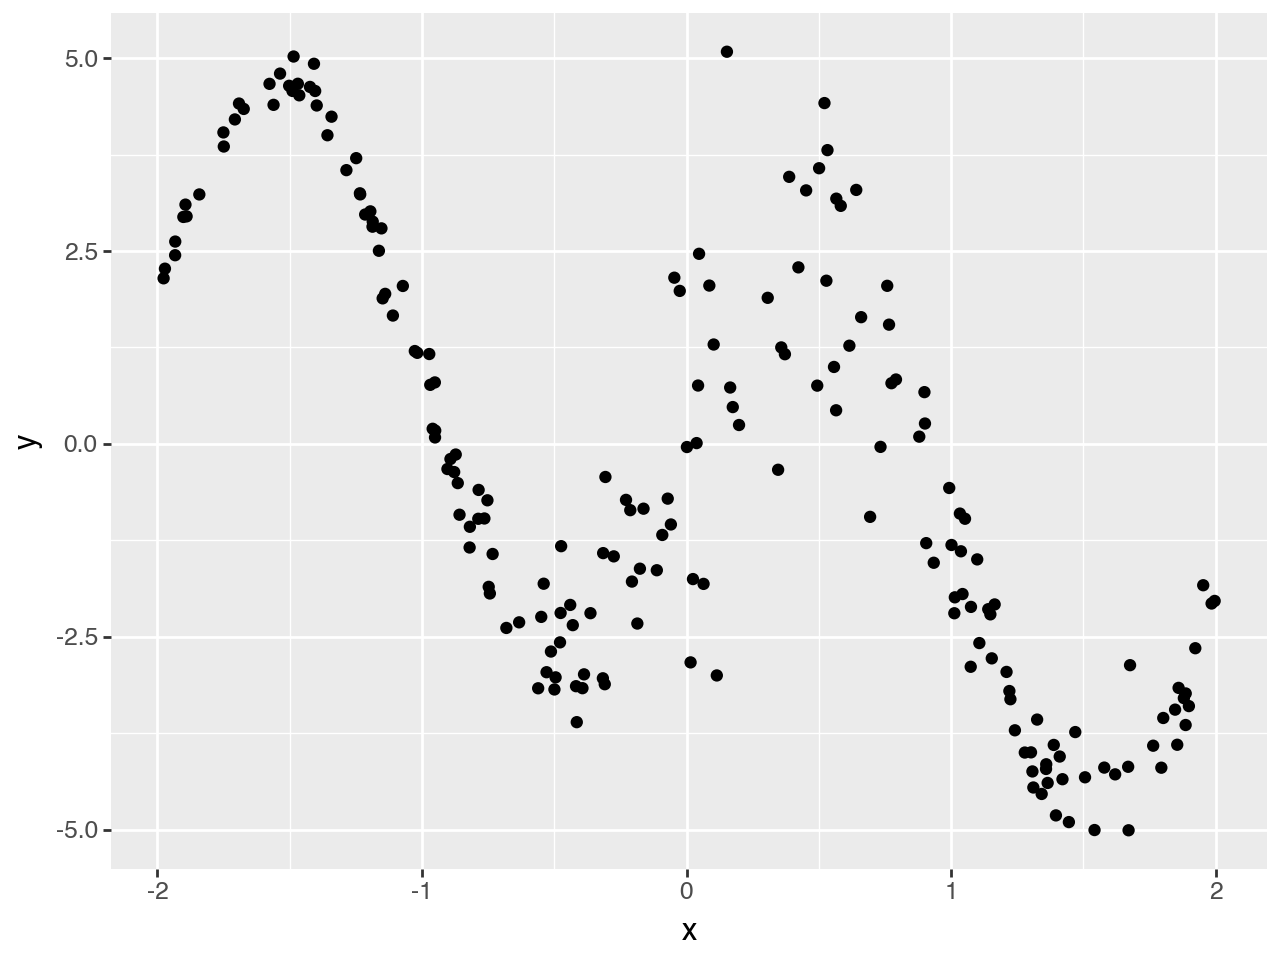

In [3]:
(p9.ggplot(df) + p9.geom_point(p9.aes("x", "y")))

## Model Definition

### Setup response model

In [4]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.y.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

In [5]:
tb = gam.TermBuilder.from_df(df)

In [6]:
loc += tb.s("x", bs="tp")
scale += tb.s("x", bs="tp")

### Build and plot model

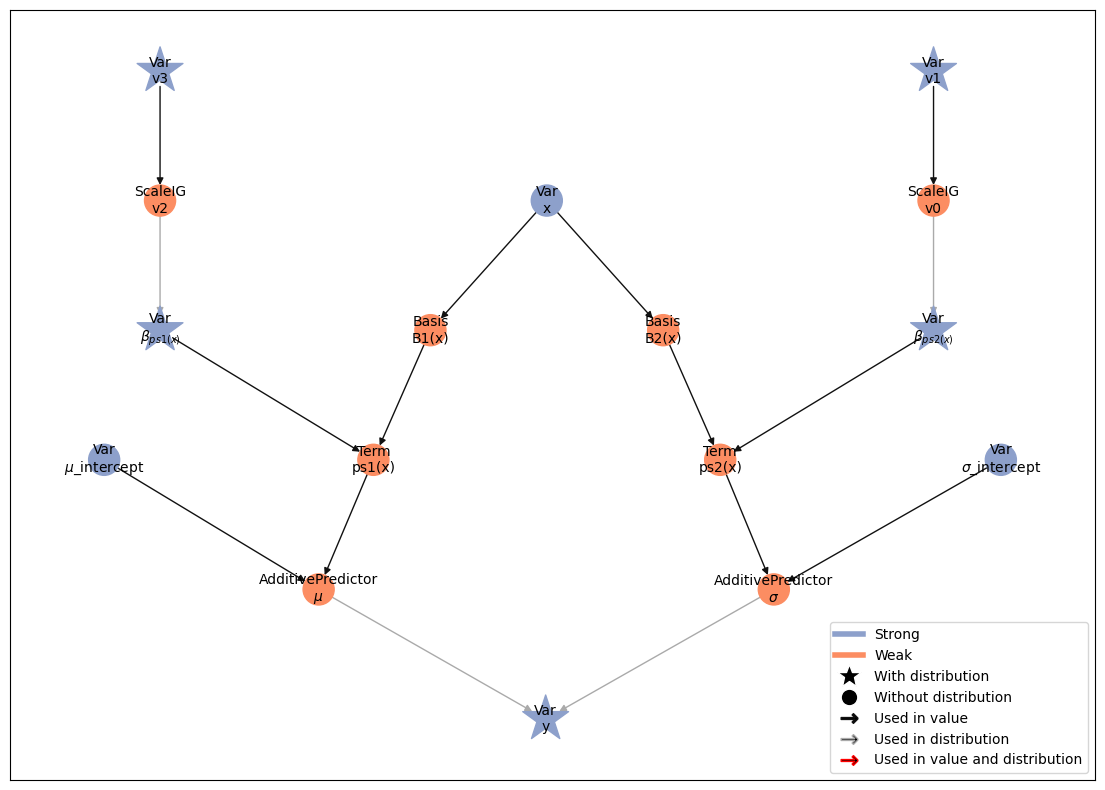

In [7]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [8]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\sigma$_intercept', '$\\beta_{ps2(x)}$', 'v1', '$\\mu$_intercept', '$\\beta_{ps1(x)}$', 'v3'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:04<00:00,  3.79chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1219.63chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1742.18chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engi

### MCMC summary

In [9]:
summary = gs.Summary(results)
summary

Parameter summary:

                             kernel        mean          sd      q_0.05  \
parameter          index                                                  
$\beta_{ps1(x)}$   (0,)   kernel_04  -16.978346    3.659737  -23.034674   
                   (1,)   kernel_04   42.991997    3.047818   38.562790   
                   (2,)   kernel_04  -53.287258    3.103084  -57.361286   
                   (3,)   kernel_04    0.533226    0.979422   -1.115065   
                   (4,)   kernel_04    4.485454    0.635049    3.505471   
                   (5,)   kernel_04    0.927438    1.027264   -0.689538   
                   (6,)   kernel_04   42.355560    2.944452   38.935663   
$\beta_{ps2(x)}$   (0,)   kernel_01    2.074703    2.790490   -2.253228   
                   (1,)   kernel_01    4.187541    2.281319    0.777659   
                   (2,)   kernel_01   -1.934773    2.000483   -5.292452   
                   (3,)   kernel_01    5.501635    0.988237    3.933972   
                   (4,)   kernel_01    0.461286    0.902579   -1.059530   
                   (5,)   kernel_01   -1.090916    1.433629   -3.372171   
                   (6,)   kernel_01    3.982782    2.904673   -0.788934   
$\mu$_intercept    ()     kernel_03   -0.331041    0.059649   -0.427661   
$\sigma$_intercept ()     kernel_00   -0.605609    0.065732   -0.694768   
v1                 ()     kernel_02   13.132317   12.158510    3.206739   
v3                 ()     kernel_05  834.499756  611.693848  324.848470   

                               q_0.5       q_0.95  sample_size     ess_bulk  \
parameter          index                                                      
$\beta_{ps1(x)}$   (0,)   -17.008942   -11.017844         4000  2902.169531   
                   (1,)    43.028446    47.405961         4000  2159.588768   
                   (2,)   -53.358459   -49.081225         4000  3715.581013   
                   (3,)     0.532945     2.136752         4000  1448.412386   
                   (4,)     4.482365     5.482820         4000  2671.449795   
                   (5,)     0.906015     2.580635         4000  3717.592805   
                   (6,)    42.420849    45.765902         4000  3099.611283   
$\beta_{ps2(x)}$   (0,)     1.940292     6.862554         4000  2948.108555   
                   (1,)     4.082919     7.955602         4000  2343.345508   
                   (2,)    -1.845096     1.191833         4000  2754.699113   
                   (3,)     5.477175     7.141029         4000  2178.974114   
                   (4,)     0.447690     1.963011         4000  2912.125721   
                   (5,)    -1.025183     1.066911         4000  2409.389839   
                   (6,)     3.935079     8.898730         4000  2882.896925   
$\mu$_intercept    ()      -0.331284    -0.234436         4000  1036.046509   
$\sigma$_intercept ()      -0.607887    -0.517662         4000  3474.928182   
v1                 ()       9.872961    32.829440         4000  2684.604964   
v3                 ()     681.300751  1815.630304         4000  4087.169645   

                             ess_tail      rhat  
parameter          index                         
$\beta_{ps1(x)}$   (0,)   3211.176430  1.001607  
                   (1,)   2681.434731  1.004503  
                   (2,)   3265.849454  1.000190  
                   (3,)   2430.082917  1.001556  
                   (4,)   3621.890823  1.004716  
                   (5,)   3889.880533  1.001449  
                   (6,)   3139.319107  1.001621  
$\beta_{ps2(x)}$   (0,)   3528.921083  0.999850  
                   (1,)   3409.048373  1.000561  
                   (2,)   3268.765038  1.000446  
                   (3,)   3229.112026  1.001059  
                   (4,)   3365.197854  1.000755  
                   (5,)   3278.854862  1.000195  
                   (6,)   3203.207304  1.001014  
$\mu$_intercept    ()     1868.693612  1.005925  
$\sigma$_intercept ()     3643.191301  1.000504 

### MCMC trace plots

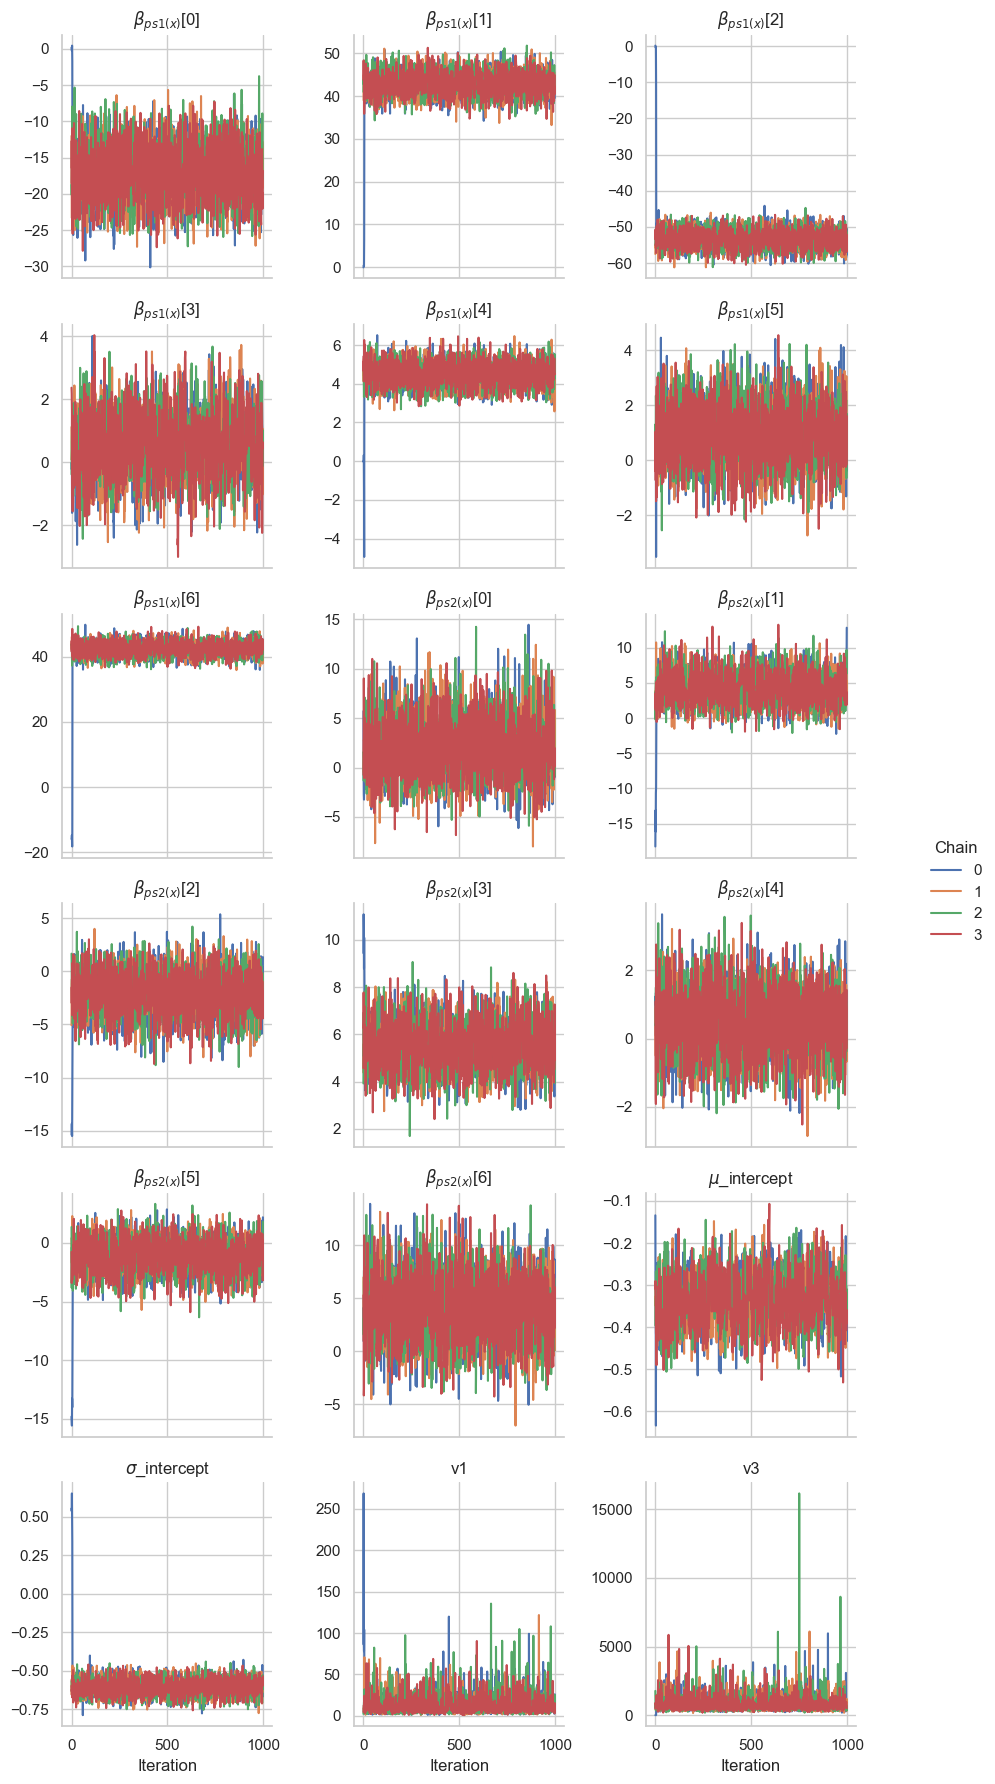

In [10]:
gs.plot_trace(results)

## Predictions

In [11]:
samples = results.get_posterior_samples()

### Predict variables at new x values

In [12]:
x_grid = jnp.linspace(x.min(), x.max(), 300)
predictions = model.predict(  # new in liesel v0.4.0
    samples=samples,
    predict=["ps1(x)", "ps2(x)", "$\\mu$", "$\\sigma$"],
    newdata={"x": x_grid},
)

predictions_summary = (
    gs.SamplesSummary(predictions).to_dataframe().reset_index()
)  # new in liesel v0.4.0
predictions_summary["x"] = np.tile(x_grid, len(predictions))

In [13]:
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,var,sd,rhat,ess_bulk,ess_tail,mcse_mean,mcse_sd,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high,x
0,$\mu$,$\mu$[0],"(0,)",4000,2.276518,0.015572,0.124789,1.000932,3225.797001,3267.859199,0.004133,0.064026,2.191634,2.270417,2.360051,2.191010,2.358374,-1.976702
1,$\mu$,$\mu$[1],"(1,)",4000,2.378121,0.014209,0.119200,1.000957,3213.757995,3225.134355,0.003945,0.061096,2.297118,2.372351,2.457416,2.297715,2.457945,-1.963415
2,$\mu$,$\mu$[2],"(2,)",4000,2.479661,0.012918,0.113656,1.000992,3203.994783,3294.190367,0.003757,0.058148,2.402171,2.474054,2.555096,2.401462,2.554071,-1.950128
3,$\mu$,$\mu$[3],"(3,)",4000,2.581060,0.011700,0.108166,1.001044,3181.205400,3184.677614,0.003569,0.055179,2.507355,2.576168,2.652604,2.505164,2.649822,-1.936841
4,$\mu$,$\mu$[4],"(4,)",4000,2.682253,0.010555,0.102740,1.001074,3163.144191,3180.646815,0.003383,0.052186,2.611462,2.678028,2.750814,2.608315,2.745970,-1.923554


### Plot fitted functions

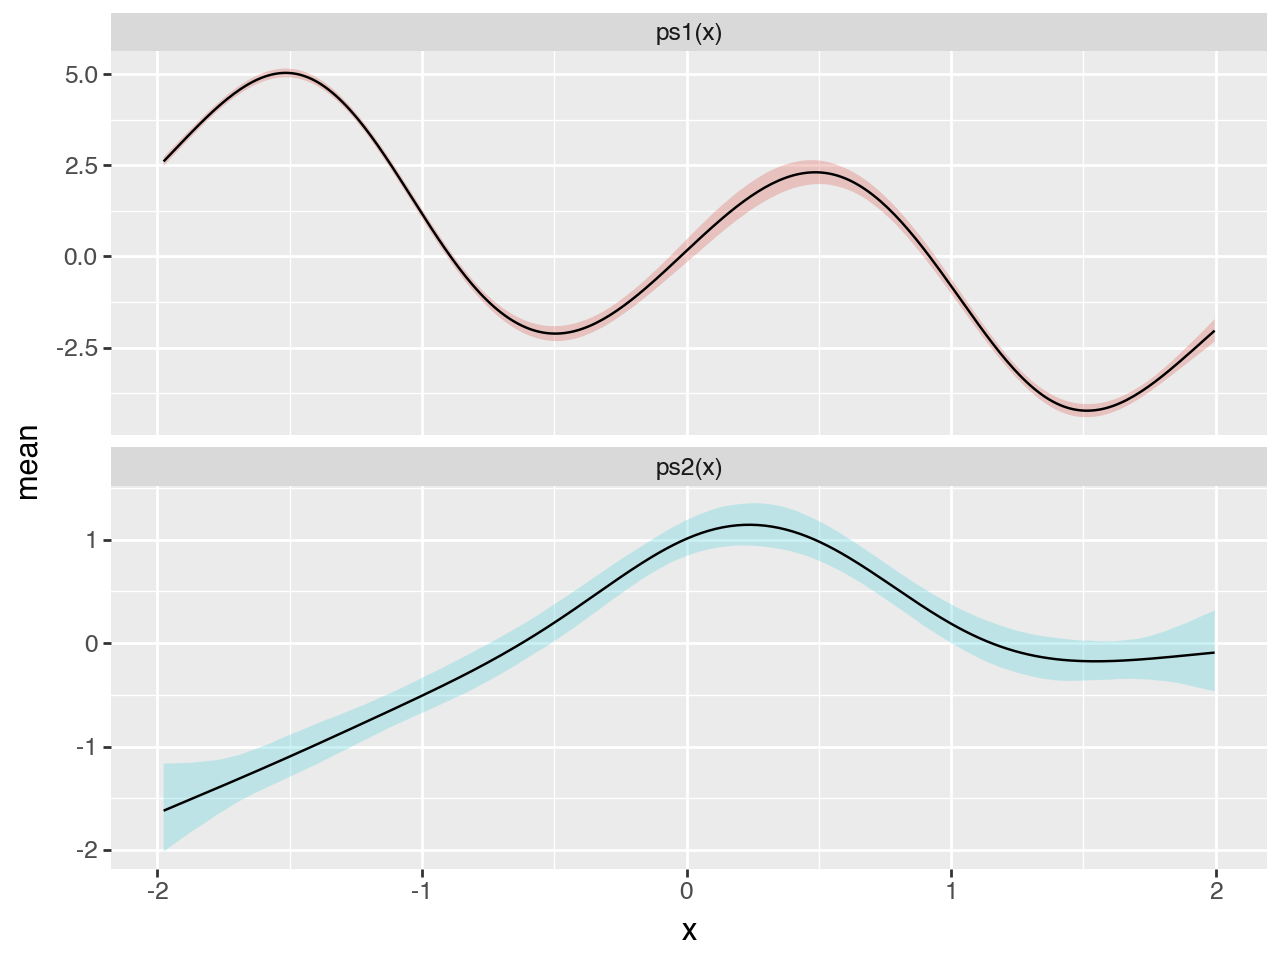

In [14]:
select = predictions_summary["variable"].isin(["ps1(x)", "ps2(x)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot parameters as functions of covariate

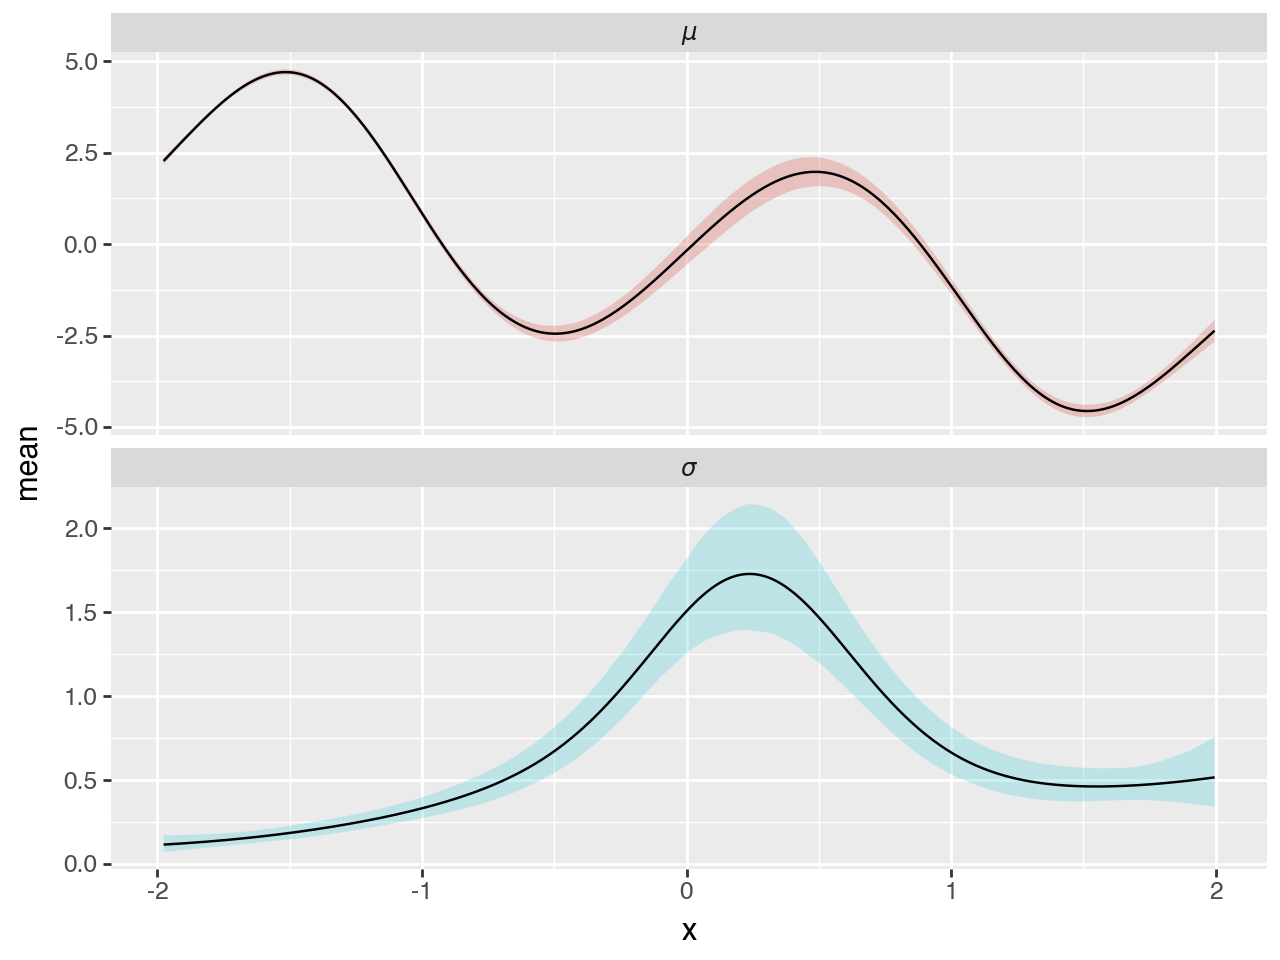

In [15]:
select = predictions_summary["variable"].isin(["$\\mu$", "$\\sigma$"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot mean function with data

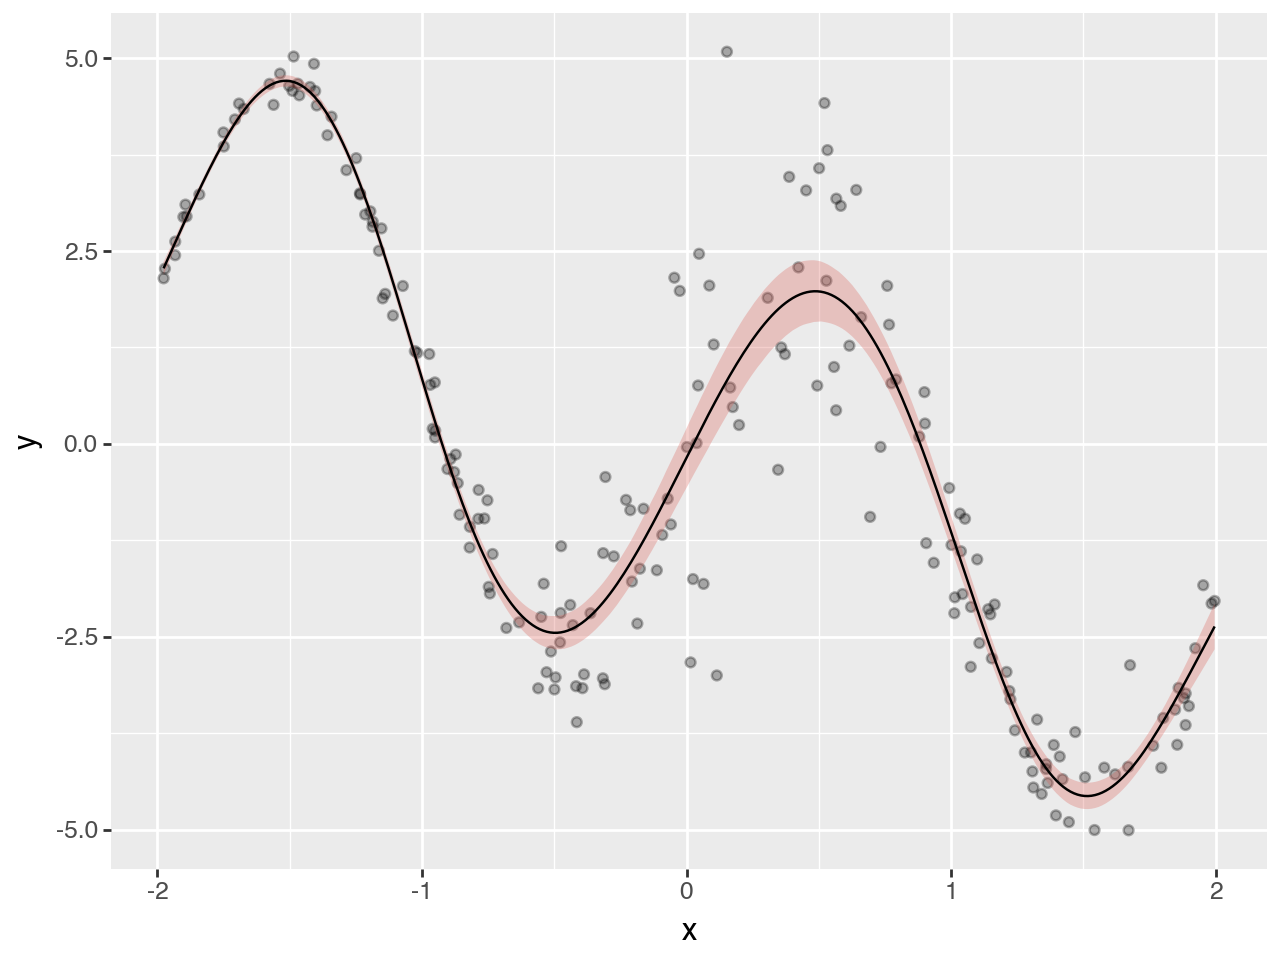

In [16]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.guides(fill="none")
)

### Plot average posterior predictive distribution

In [17]:
select = predictions_summary["variable"].isin(["$\\mu$", "$\\sigma$"])
mu_sigma_df = (
    predictions_summary[select][["variable", "mean", "x"]]
    .pivot(index="x", columns=["variable"], values="mean")
    .reset_index()
)

mu_sigma_df["low"] = mu_sigma_df["$\\mu$"] - mu_sigma_df["$\\sigma$"]
mu_sigma_df["high"] = mu_sigma_df["$\\mu$"] + mu_sigma_df["$\\sigma$"]
mu_sigma_df

variable,x,$\mu$,$\sigma$,low,high
0,-1.976702,2.276518,0.114951,2.161567,2.391470
1,-1.963415,2.378121,0.116175,2.261946,2.494295
2,-1.950128,2.479661,0.117433,2.362228,2.597095
3,-1.936841,2.581060,0.118727,2.462333,2.699788
4,-1.923554,2.682253,0.120058,2.562195,2.802310
...,...,...,...,...,...
295,1.942956,-2.712146,0.504911,-3.217057,-2.207235
296,1.956243,-2.625837,0.507584,-3.133421,-2.118253
297,1.969530,-2.539387,0.510327,-3.049713,-2.029060
298,1.982817,-2.452844,0.513139,-2.965983,-1.939704


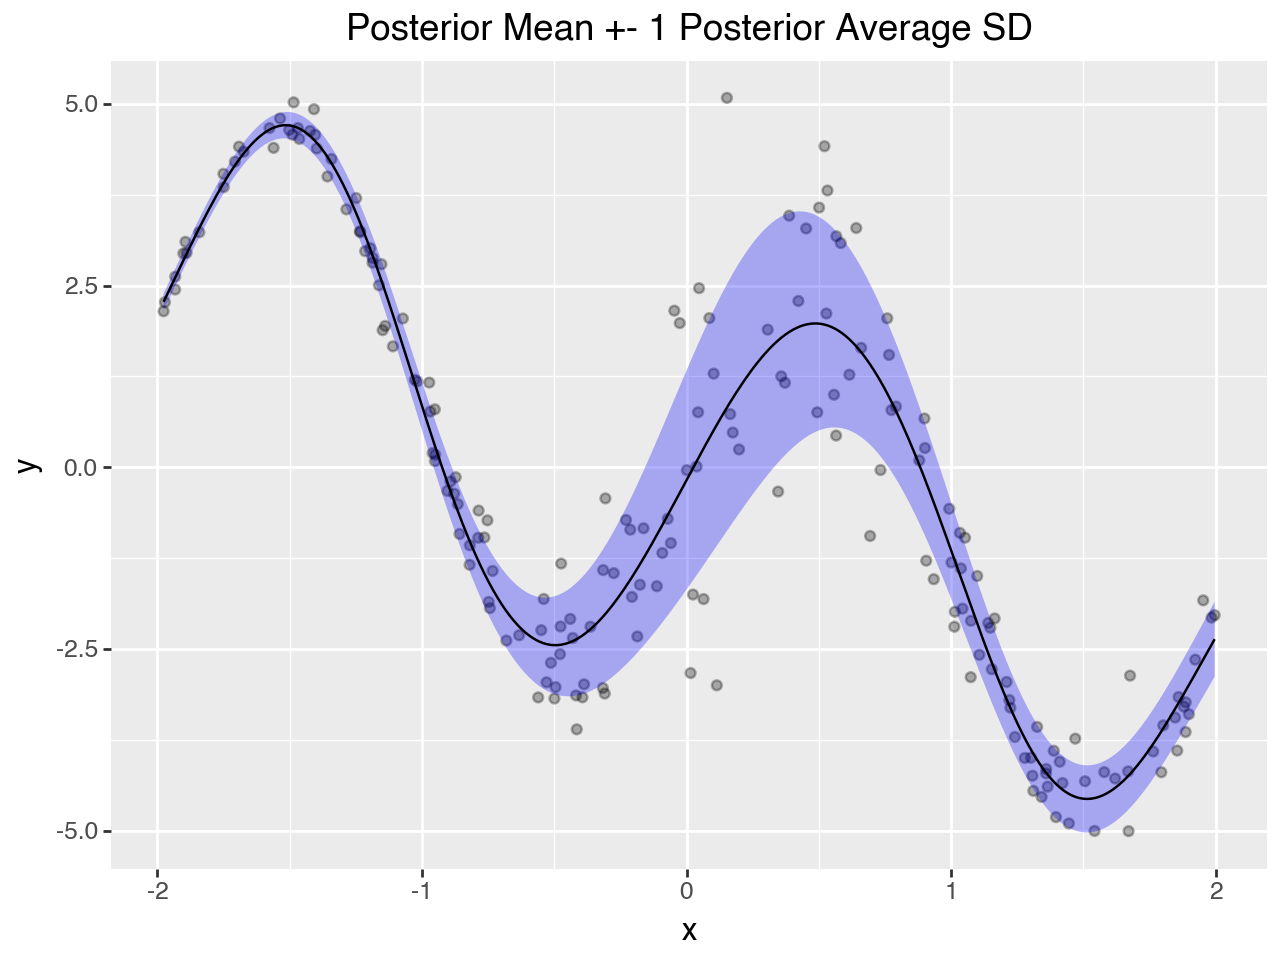

In [18]:
(
    p9.ggplot()
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="low", ymax="high"),
        alpha=0.3,
        fill="blue",
        data=mu_sigma_df,
    )
    + p9.geom_line(p9.aes("x", "$\\mu$"), data=mu_sigma_df)
    + p9.labs(title="Posterior Mean +- 1 Posterior Average SD")
    + p9.guides(fill="none")
)

## Posterior Predictive Checks

### Draw posterior predictive samples

In [19]:
ppsamples = model.sample(  # new in liesel v0.4.0
    shape=(3,), seed=jax.random.key(1), posterior_samples=samples
)

ppsamples["y"].shape

(3, 4, 1000, 200)

In [20]:
# can be reshaped to concatenate the first two axes
_ = ppsamples["y"].reshape(-1, *ppsamples["y"].shape[2:])

### Summarize posterior predictive samples

In [21]:
ppsamples = model.sample(
    shape=(),  # just draw 1 value for each posterior sample
    seed=jax.random.key(1),
    posterior_samples=samples,
)

# summarise ppsamples
ppsamples_summary = gs.SamplesSummary(ppsamples).to_dataframe().reset_index()

# add covariate to df
ppsamples_summary["x"] = df["x"].to_numpy()

### Plot posterior predictive summary

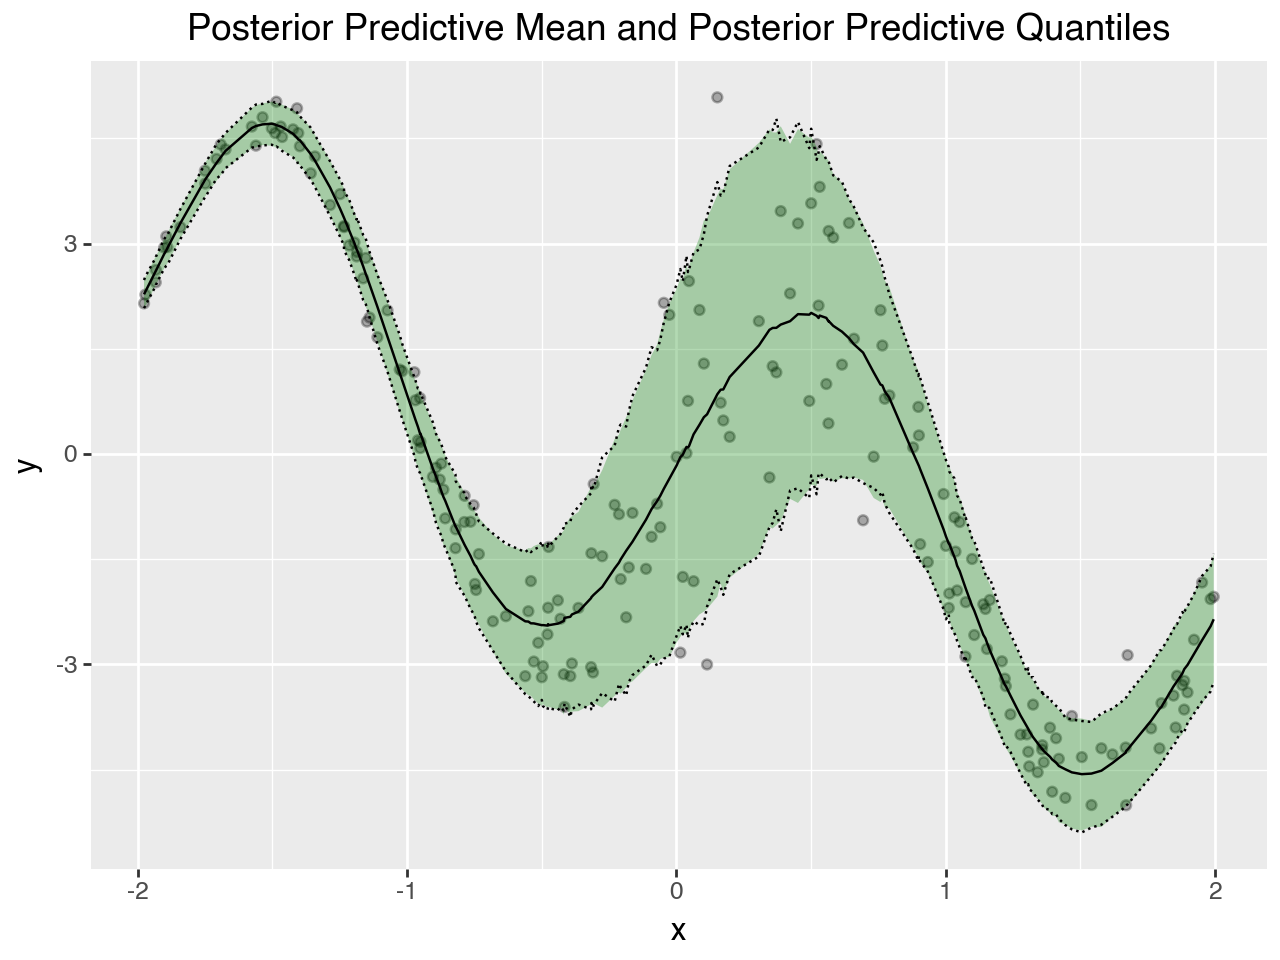

In [22]:
(
    p9.ggplot(ppsamples_summary)
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
    )
    + p9.geom_line(p9.aes("x", "hdi_low"), linetype="dotted")
    + p9.geom_line(p9.aes("x", "hdi_high"), linetype="dotted")
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.labs(title="Posterior Predictive Mean and Posterior Predictive Quantiles")
    + p9.guides(fill="none")
)

### Plot posterior predictive samples

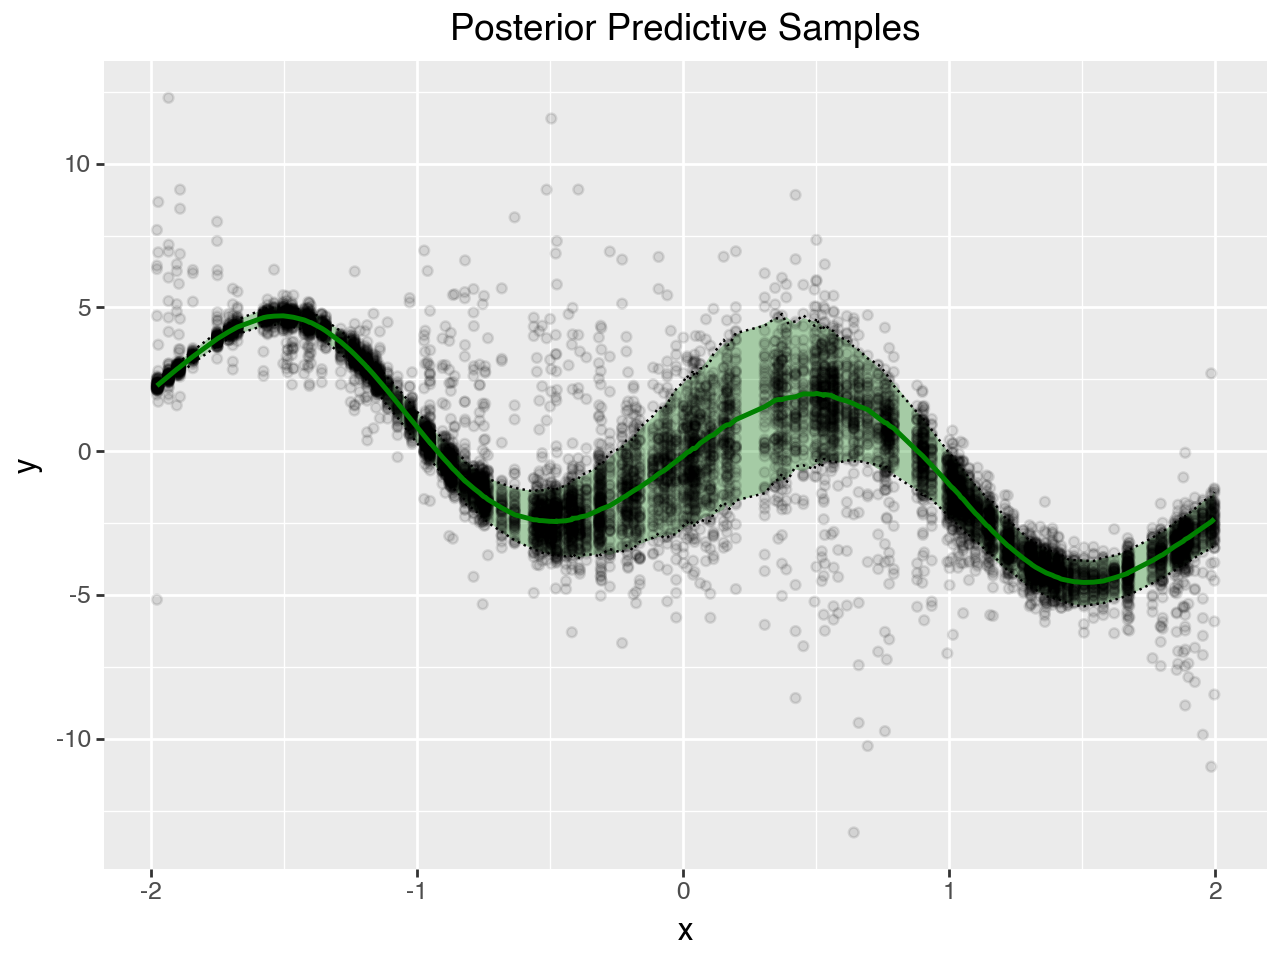

In [23]:
ppsamples_reshaped = ppsamples["y"].reshape(-1, *ppsamples["y"].shape[2:])
ppsamples_df = pd.DataFrame(ppsamples_reshaped.T)
ppsamples_df["x"] = df["x"].to_numpy()
ppsamples_df = ppsamples_df.melt(id_vars=["x"], value_name="y", var_name="sample")
ppsamples_df[ppsamples_df["sample"].isin(range(5))]


nsamples = 50


(
    p9.ggplot(ppsamples_df[ppsamples_df["sample"].isin(range(nsamples))])
    + p9.labs(title="Posterior Predictive Samples")
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
        data=ppsamples_summary,
    )
    + p9.geom_point(p9.aes("x", "y"), alpha=0.1)
    + p9.geom_line(p9.aes("x", "hdi_low"), linetype="dotted", data=ppsamples_summary)
    + p9.geom_line(p9.aes("x", "hdi_high"), linetype="dotted", data=ppsamples_summary)
    + p9.geom_line(p9.aes("x", "mean"), color="green", size=1, data=ppsamples_summary)
)

In [24]:
from liesel_gam import plots

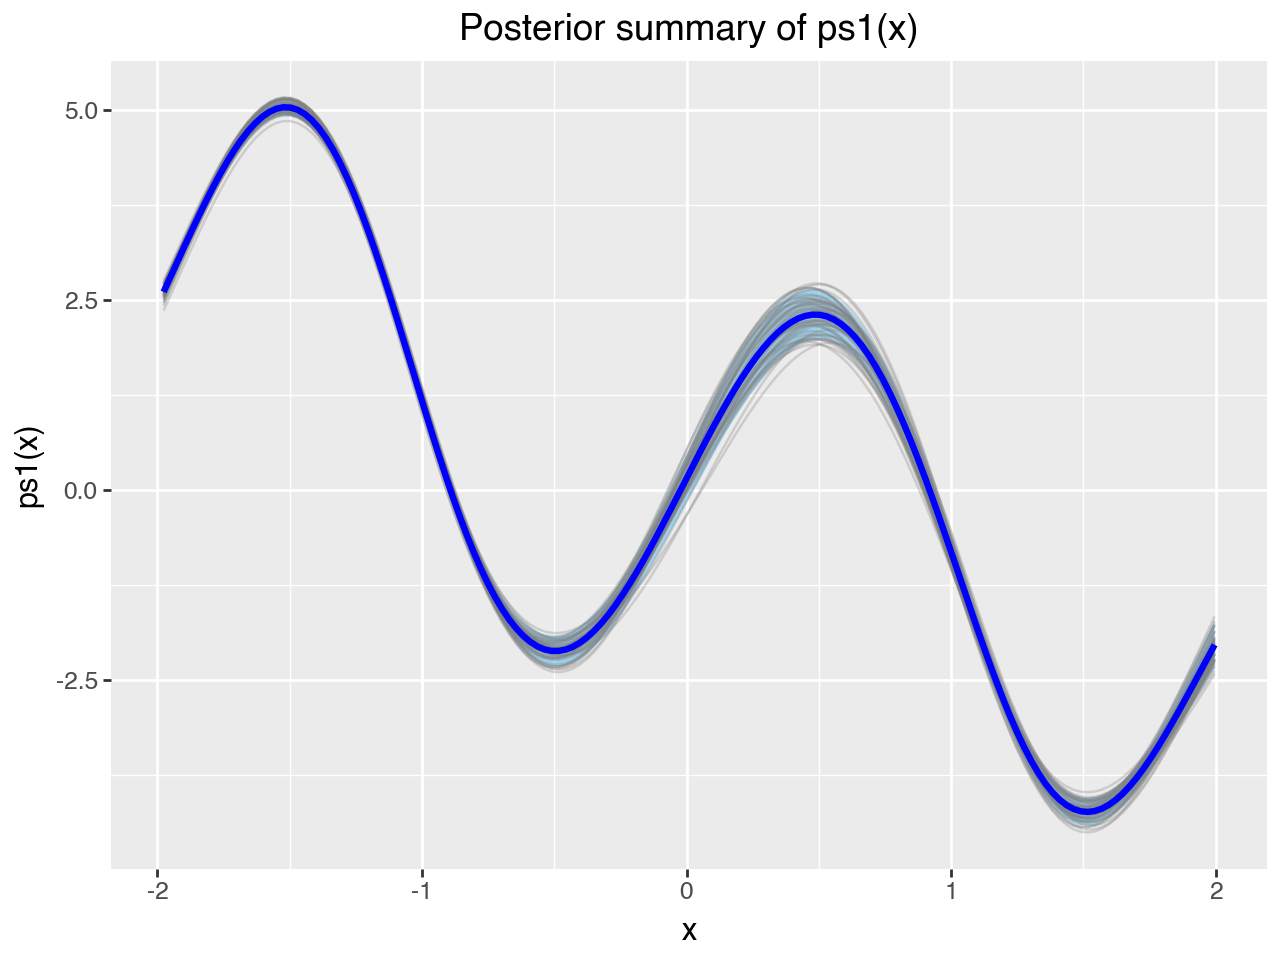

In [25]:
plots.plot_1d_smooth(loc.terms["ps1(x)"], samples)